In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline


In [2]:
import numpy as np
import pandas as pd
import matplotlib, collections, itertools, os, re, textwrap, logging
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from functools import reduce

from logging.config import dictConfig
from logging import getLogger

dictConfig(dict(
    version = 1,
    formatters = {'f': {'format': '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'}},
    handlers = {
        'h': {'class': 'logging.StreamHandler','formatter': 'f',
              'level': logging.DEBUG}},
    root = {'handlers': ['h'], 'level': logging.DEBUG,},
))

matplotlib.rc('font',**{'size':16, 'family':'sans-serif','sans-serif':['HelveticaNeue', 'Helvetica']})

logger = getLogger('notebook')


In [3]:
import yt_misc_py as yt_misc

import rivas_decomposition_py as decomposition


In [6]:
repo_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath(os.getcwd()))))

out_dir = os.path.join(
    repo_dir, 'figs', os.path.basename(os.path.realpath(os.getcwd())),
)


In [7]:
great_dir = os.path.join(
    repo_dir, 'private_data', 'results',
    'dev_allNonMHC_z_center_p0001_100PCs_20180129.npz',
    'great',
    'results'
)

In [8]:
d_all = decomposition.decomposition(os.path.join(
    repo_dir, 'private_data', 'npz', 
    'dev_allNonMHC_z_center_p0001_100PCs_20180129.npz'
))


2019-01-29 20:28:44,698 data_load_from_npz INFO     reading data from /Users/yosuke/repos/rivas-lab/decomposition/private_data/npz/dev_allNonMHC_z_center_p0001_100PCs_20180129.npz


In [14]:
def read_great_onto_to_gene_dict():
    ontoToGene_df = pd.read_table(
        os.path.join(
            repo_dir, 'private_data', 'great_ontology', 
            'MGIPhenotype_hg19_20181029',
            'ontoToGene.canon'
        ),
        names=['onto_ID', 'GREAT_gene_ID']
    )    
    ontoToGene_grouped_df = ontoToGene_df.groupby('onto_ID', as_index=False).agg(
        lambda x: set(x) 
    )
    return dict(zip(
        ontoToGene_grouped_df['onto_ID'], 
        ontoToGene_grouped_df['GREAT_gene_ID']
    ))
    

In [15]:
great_onto_to_gene_dict = read_great_onto_to_gene_dict()

In [16]:
def jaccard_index_onto_terms(
    onto_ids_x, onto_ids_y, 
    great_onto_to_gene_dict = great_onto_to_gene_dict
):
    if(len(onto_ids_x) > 0):
        gene_set_x = reduce(
            lambda s1, s2: s1.union(s2),
            [great_onto_to_gene_dict[id] for id in onto_ids_x]
        )
    else:
        gene_set_x = set()
    if(len(onto_ids_y) > 0):
        gene_set_y = reduce(
            lambda s1, s2: s1.union(s2),
            [great_onto_to_gene_dict[id] for id in onto_ids_y]
        )
    else:
        gene_set_y = set()

    union_len = len(gene_set_x.union(gene_set_y))
    intersection_len = len(gene_set_x.intersection(gene_set_y))
    if(union_len > 0):
        Jaccard_index = intersection_len * 1.0 / union_len
    else:
        Jaccard_index = 0
    return Jaccard_index

In [17]:
def read_great_PC(pc_index, BFold=2, BPval=float('5e-7'), sort_by='BFold'):
    pc_zero_based_index = pc_index - 1
    ontology = 'MGIPhenotype'
    return yt_misc.read_great_res(
        os.path.join(
            great_dir, 'PC{}'.format(pc_zero_based_index), 
            '{}.tsv'.format(ontology)
        ),
        BFold=BFold, BPval=BPval, sort_by=sort_by
    )

## How many time each of the components are chosen as the top component?

In [19]:
cnt = collections.Counter([
    d_all.get_kth_pc_for_phe_by_index(index=x, k=1) + 1
    for x in range(d_all.d['n_phes'])
])

<BarContainer object of 79 artists>

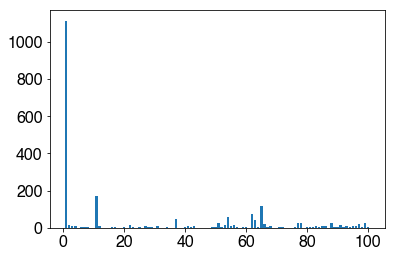

In [34]:
plt.bar(
    cnt.keys(),
    cnt.values()
)

In [20]:
cnt

Counter({1: 1114,
         2: 14,
         3: 7,
         4: 8,
         6: 4,
         7: 4,
         8: 2,
         10: 1,
         11: 172,
         12: 12,
         13: 1,
         15: 1,
         16: 4,
         17: 5,
         18: 1,
         20: 2,
         22: 14,
         23: 6,
         25: 2,
         27: 9,
         28: 6,
         29: 3,
         31: 10,
         32: 1,
         34: 2,
         37: 49,
         38: 1,
         39: 1,
         40: 4,
         41: 7,
         42: 6,
         43: 9,
         44: 1,
         46: 1,
         49: 4,
         50: 3,
         51: 28,
         52: 2,
         53: 13,
         54: 60,
         55: 9,
         56: 17,
         57: 5,
         59: 2,
         60: 4,
         61: 1,
         62: 73,
         63: 44,
         64: 5,
         65: 116,
         66: 18,
         67: 2,
         68: 7,
         71: 3,
         72: 4,
         74: 1,
         76: 2,
         77: 27,
         78: 26,
         80: 3,
         81: 5,
         8

## How similar the GREAT enrichments are across 100 PCs?

In [23]:
def get_topk_terms(great_df, topk = 5):
    return list(great_df['# ID'])[:topk]

In [21]:
great_plot_dfs = [
    read_great_PC(x + 1, BFold=2, BPval=float('5e-7')) 
    for x in range(100)
]

In [22]:
great_raw_dfs = [
    read_great_PC(x + 1, BPval=float('5e-6')) 
    for x in range(100)
]

In [24]:
top1_plot = [
    get_topk_terms(great_df, topk = 1) 
    for great_df in great_plot_dfs
]

In [25]:
top5_plot = [
    get_topk_terms(great_df, topk = 5) 
    for great_df in great_plot_dfs
]

In [35]:
top1_raw = [
    get_topk_terms(great_df, topk = 1) 
    for great_df in great_raw_dfs
]

In [36]:
top5_raw = [
    get_topk_terms(great_df, topk = 5) 
    for great_df in great_raw_dfs
]

#### let's count how many times do we get the same term (top 1)

(array([26.,  7.,  3.,  3.,  2.,  1.,  2.,  1.,  0.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 9 Patch objects>)

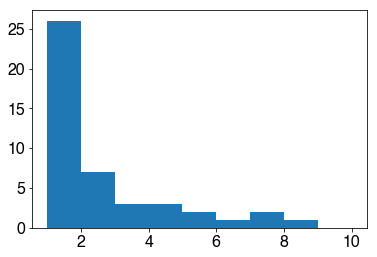

In [26]:
plt.hist(
    list(collections.Counter([
        x for x in itertools.chain.from_iterable(top1_plot)
    ]).values()), bins=range(1, 11)
)

#### let's count how many times do we get the same term (top 5)

(array([ 116.,   39.,   13.,    8.,    6.,    1.,    2.,    2.,    0.,
           0.,    1.,    2.,    1.,    0.,    1.,    0.,    0.,    0.,
           0.,    1.,    1.,    0.,    0.,    2.,    0.,    0.,    0.,
           0.,    0.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 29 Patch objects>)

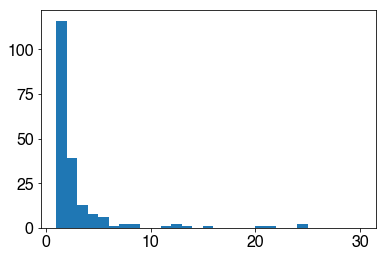

In [135]:
plt.hist(
    list(collections.Counter([
        x for x in itertools.chain.from_iterable(top5_plot)
    ]).values()), bins=range(1, 31)
)

In [27]:
def compute_jaccard_index_mat(topk_terms_list):
    return np.array([
        [
            jaccard_index_onto_terms(x, y) 
            for y in topk_terms_list
        ] for x in topk_terms_list
    ])
        

In [118]:
def plot_jaccard_index_mat(mat, title, save=None):
    fig = plt.figure(figsize=(6,6))
    gs = gridspec.GridSpec(1, 1)
    fig_axs = [fig.add_subplot(sp) for sp in gs]
    ax=fig_axs[0]
    im = ax.imshow(mat)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Jaccard index (pairwise gene set similarity)', rotation=-90, va="bottom")
    ax.set_xlabel('DeGAs components')
    ax.set_ylabel('DeGAs components')
    ticks = np.arange(0, mat.shape[0], 20) + 19
    ticklabels = ['{}'.format(x + 1) for x in ticks]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(ticklabels)
    ax.set_yticklabels(ticklabels)
    ax.set_title(title)
#     gs.tight_layout(fig, rect=[0, 0, 1, 1])  
    if(save is not None):
        save_dirname=os.path.dirname(save)
        if(not os.path.exists(save_dirname)):
            os.mkdir(save_dirname)
        for ext in ['png', 'pdf']:
            fig.savefig(
                '{}.{}'.format(save, ext), 
                bbox_inches="tight", 
                pad_inches=0.0
            )
    

2019-01-30 17:30:15,944 matplotlib.backends.backend_pdf DEBUG    Assigning font /b'F1' = '/Users/yosuke/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf'
2019-01-30 17:30:16,010 matplotlib.backends.backend_pdf DEBUG    Embedding font /Users/yosuke/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf.
2019-01-30 17:30:16,013 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.
2019-01-30 17:30:16,184 matplotlib.backends.backend_pdf DEBUG    Assigning font /b'F1' = '/Users/yosuke/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf'
2019-01-30 17:30:16,241 matplotlib.backends.backend_pdf DEBUG    Embedding font /Users/yosuke/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf.
2019-01-30 17:30:16,244 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


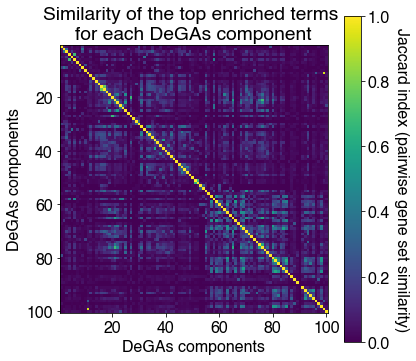

In [119]:
plot_jaccard_index_mat(
    compute_jaccard_index_mat(top5_plot),
    'Similarity of the top enriched terms \nfor each DeGAs component',
    save=os.path.join(out_dir, 'Heatmap_top5terms_plot')
)

In [123]:
np.median(compute_jaccard_index_mat(top5_plot)[np.triu_indices(100, 1)])

0.028985507246376812

## the followings are backup figures

2019-01-30 17:30:54,408 matplotlib.backends.backend_pdf DEBUG    Assigning font /b'F1' = '/Users/yosuke/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf'
2019-01-30 17:30:54,463 matplotlib.backends.backend_pdf DEBUG    Embedding font /Users/yosuke/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf.
2019-01-30 17:30:54,466 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.
2019-01-30 17:30:54,616 matplotlib.backends.backend_pdf DEBUG    Assigning font /b'F1' = '/Users/yosuke/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf'
2019-01-30 17:30:54,663 matplotlib.backends.backend_pdf DEBUG    Embedding font /Users/yosuke/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf.
2019-01-30 17:30:54,665 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


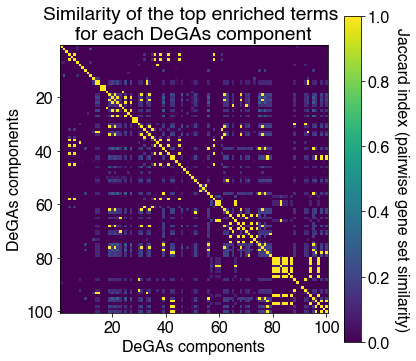

In [120]:
plot_jaccard_index_mat(
    compute_jaccard_index_mat(top1_plot),
    'Similarity of the top enriched terms \nfor each DeGAs component',
    save=os.path.join(out_dir, 'other_params', 'Heatmap_top1terms_plot')
)

2019-01-30 17:31:05,650 matplotlib.backends.backend_pdf DEBUG    Assigning font /b'F1' = '/Users/yosuke/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf'
2019-01-30 17:31:05,695 matplotlib.backends.backend_pdf DEBUG    Embedding font /Users/yosuke/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf.
2019-01-30 17:31:05,697 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.
2019-01-30 17:31:05,819 matplotlib.backends.backend_pdf DEBUG    Assigning font /b'F1' = '/Users/yosuke/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf'
2019-01-30 17:31:05,861 matplotlib.backends.backend_pdf DEBUG    Embedding font /Users/yosuke/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf.
2019-01-30 17:31:05,863 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


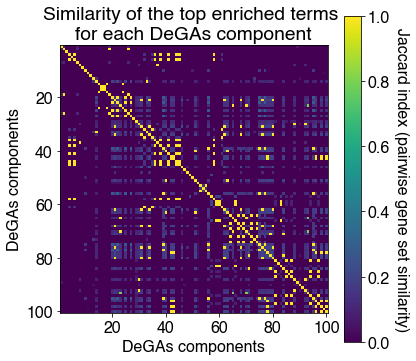

In [121]:
plot_jaccard_index_mat(
    compute_jaccard_index_mat(top1_raw),
    'Similarity of the top enriched terms \nfor each DeGAs component',
    save=os.path.join(out_dir, 'other_params', 'Heatmap_top1terms_raw')
)

2019-01-30 17:31:15,158 matplotlib.backends.backend_pdf DEBUG    Assigning font /b'F1' = '/Users/yosuke/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf'
2019-01-30 17:31:15,201 matplotlib.backends.backend_pdf DEBUG    Embedding font /Users/yosuke/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf.
2019-01-30 17:31:15,203 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.
2019-01-30 17:31:15,338 matplotlib.backends.backend_pdf DEBUG    Assigning font /b'F1' = '/Users/yosuke/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf'
2019-01-30 17:31:15,390 matplotlib.backends.backend_pdf DEBUG    Embedding font /Users/yosuke/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf.
2019-01-30 17:31:15,392 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


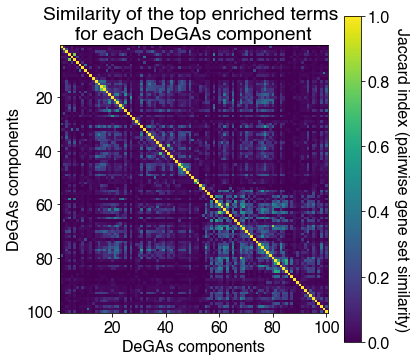

In [122]:
plot_jaccard_index_mat(
    compute_jaccard_index_mat(top5_raw),
    'Similarity of the top enriched terms \nfor each DeGAs component',
    save=os.path.join(out_dir, 'other_params', 'Heatmap_top1terms_raw')
)